In [1]:
# NOTE: installation of modules is required before running this notebook. (See README.md)
# Also, sklearn and matplotlib is required to run this notebook (run "pip3 install scikit-learn matplotlib" for installation)

In [10]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from inc_pca import IncPCA

In [11]:
#
# load data
#
iris = datasets.load_iris()
shuffled_order = [
    78, 142, 39, 31, 53, 42, 89, 5, 91, 65, 19, 49, 112, 125, 96, 134, 83, 77,
    0, 79, 100, 92, 109, 38, 67, 84, 123, 80, 62, 126, 144, 107, 50, 149, 127,
    46, 21, 136, 41, 35, 20, 139, 82, 27, 18, 66, 118, 145, 124, 93, 129, 97,
    146, 138, 120, 95, 94, 147, 43, 143, 13, 131, 116, 15, 3, 14, 37, 73, 26,
    70, 99, 25, 7, 23, 36, 76, 119, 88, 44, 110, 140, 57, 105, 34, 32, 103, 74,
    114, 87, 106, 111, 40, 117, 81, 86, 63, 56, 133, 33, 4, 9, 1, 51, 24, 30,
    72, 69, 61, 64, 113, 8, 135, 55, 71, 137, 85, 108, 128, 6, 90, 121, 16,
    148, 47, 115, 59, 17, 12, 60, 101, 52, 104, 68, 54, 2, 11, 22, 130, 10, 29,
    102, 45, 141, 122, 58, 132, 28, 75, 98, 48
]
X = iris.data[shuffled_order, ]
group = iris.target[shuffled_order]
target_names = iris.target_names

In [14]:
#
# 1. incremental PCA and geometric transformation examples
#

ipca = IncPCA(2, 1.0)
m = 2  # number of new points

# process 20 x m new points
for i in range(20):
    ipca.partial_fit(X[m * i:m * (i + 1), ])
Y_a = ipca.transform(X[0:m * 20, ])

# add m new points
ipca.partial_fit(X[m * 21:m * 22, ])
Y_b = ipca.transform(X[0:m * 22, ])

# apply the geometric transformation
Y_bg = IncPCA.geom_trans(Y_a, Y_b)

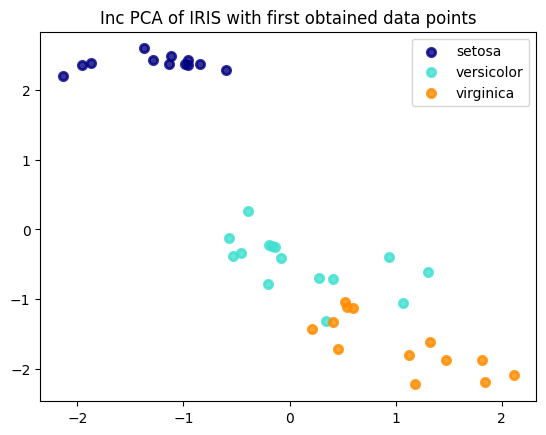

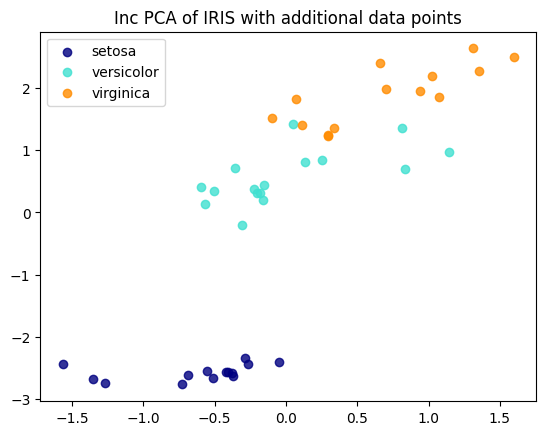

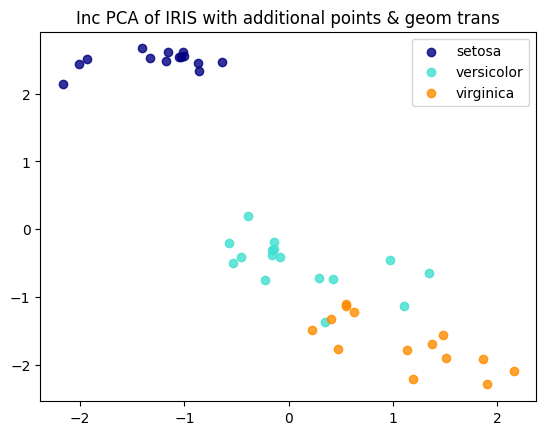

In [5]:
# plot results
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        Y_a[group[0:len(Y_a)] == i, 0],
        Y_a[group[0:len(Y_a)] == i, 1],
        color=color,
        alpha=.8,
        lw=lw,
        label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Inc PCA of IRIS with first obtained data points')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        Y_b[group[0:len(Y_b)] == i, 0],
        Y_b[group[0:len(Y_b)] == i, 1],
        color=color,
        alpha=.8,
        label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Inc PCA of IRIS with additional data points')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        Y_bg[group[0:len(Y_bg)] == i, 0],
        Y_bg[group[0:len(Y_bg)] == i, 1],
        color=color,
        alpha=.8,
        label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Inc PCA of IRIS with additional points & geom trans')

plt.show()

In [6]:
#
# 2. pos estimation example
#

# incremental PCA result with only 3 features
ipca_only_3d = IncPCA(2, 1.0)
for i in range(22):
    ipca_only_3d.partial_fit(X[m * i:m * (i + 1), 0:3])
Y_only_3d = ipca_only_3d.transform(X[0:m * 22, 0:3])

# compare actual position with PCA resutl with full features and estimated pos
actual_pos = ipca.transform([X[48, ]])[0]
pos_only_3d = ipca_only_3d.transform([X[48, 0:3]])[0]
est_pos, uncert_u = IncPCA.pos_est(pos_only_3d, Y_only_3d, Y_b)
beta = 0.5
uncert_w = beta * uncert_u + (1.0 - beta) * ipca.get_uncert_v(3)

print("actual pos:", actual_pos)
print("estimated pos:", est_pos)
print("combined uncertainty W:", uncert_w)

actual pos: [0.98274301 2.04058392]
estimated pos: [0.95121082 1.78701966]
combined uncertainty W: 0.3540730908398804


In [7]:
#
# 3. example of updating beta (combined uncertainty weight)
#

# prepare ipca for each dimension l (l: {1, 2, 3, 4})
ipcas = [
    IncPCA(1, 1.0),
    IncPCA(2, 1.0),
    IncPCA(2, 1.0),
    IncPCA(2, 1.0)
]

D = len(ipcas)
for l in range(len(ipcas)):
    ipcas[l].partial_fit(X[0:10, 0:l + 1])

# initial parameters
beta = 0.1
sq_grad = 0.0
sq_dbeta = 0.0
betas_for_plot = [beta]

# update the model and beta
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2)

for iter in range(50):
    n = 10 + m * iter
    sprimes = []
    uncert_vs = np.zeros(D)
    uncert_us = np.zeros((D, m))

    Y_D = ipcas[D - 1].transform(X[0:n, 0:D])

    for l in range(D):
        ipcas[l].partial_fit(X[n:n + m, 0:l + 1])
        Y_l = ipcas[l].transform(X[0:n, 0:l + 1])
        # add column with zeros when l=1 to make 2D points
        if (l == 0):
            Y_l = np.concatenate((Y_l, np.zeros((n, 1))), axis=1)

        uncert_vs[l] = ipcas[D - 1].get_uncert_v(l)
        
        sigma = np.zeros((m, n))
        sprime = np.zeros((m, n))
        
        for i in range(n):
            for u in range(m):
                new_point = [X[n + u, 0:l + 1]]
                new_point_pos = ipcas[l].transform(new_point)

                # add column with zeros when l=1 to make 2D points
                if (l == 0):
                    new_point_pos = np.concatenate(
                        (new_point_pos, np.zeros((1, 1))), axis=1)

                est_pos, uncert_u = IncPCA.pos_est(new_point_pos, Y_l, Y_D)

                sigma[u, i] = distance(Y_D[-(m + u)], Y_D[i])
                sprime[u, i] = distance(Y_l[-(m + u)], Y_l[i])
                uncert_us[l, u] = uncert_u
        sprimes.append(sprime)

    beta, sq_grad, sq_dbeta = IncPCA.update_uncert_weight(
        beta, sq_grad, sq_dbeta, sigma, sprimes, uncert_us, uncert_vs)
    betas_for_plot.append(beta)

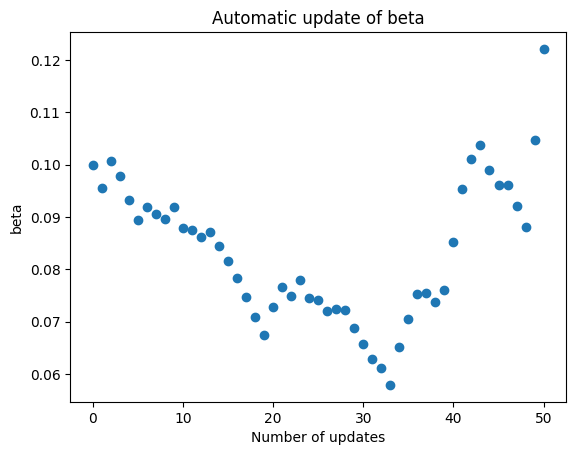

In [8]:
# plot a result
plt.scatter(list(range(len(betas_for_plot))), betas_for_plot)
plt.xlabel('Number of updates')
plt.ylabel('beta')
plt.title('Automatic update of beta')
plt.show()